In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import json
import ast
import requests
import os


In [2]:
# Import movies dataset
movie_metadata = pd.read_csv('dataset/MovieSummaries/movie.metadata.tsv', sep='\t', header=None , 
names=['WikiID', 'FreebaseID', 'Name', 'Release', 'BoxRevenue', 'Runtime', 'Languages', 'Countries', 'Genres'])
movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [3]:

movie_metadata[ movie_metadata.FreebaseID == '/m/0g42sjq']

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
33207,31430255,/m/0g42sjq,My Reincarnation,2010,NaN,82.0,"{""/m/01kbdv"": ""Tibetan languages"", ""/m/02bjrlw...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03bxz7"": ""Biographical film"", ""/m/017fp"":..."


In [4]:
# Preprocessing dataset: convert dates to datetime, countries, genres and languages to string

movie_metadata["Release"] = movie_metadata["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
movie_metadata["Countries"] = movie_metadata["Countries"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Languages"] = movie_metadata["Languages"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata["Genres"] = movie_metadata["Genres"].apply(lambda x: list(ast.literal_eval(x).values()) if pd.notnull(x) else x)
movie_metadata = movie_metadata.dropna(subset=["Release", "Countries", "Genres"])

movie_metadata.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama]


In [5]:
movie_metadata = movie_metadata[movie_metadata["Release"].apply(lambda x: 1912<x<2014)]

In [6]:
# Explode countries for visualization
processed = movie_metadata
processed = processed.explode(column="Countries").reset_index(drop = True)
processed.head()

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],Norway,"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],Germany,[Drama]


In [7]:
# Import characters dataset and preprocessing
characters = pd.read_csv('dataset/MovieSummaries/character.metadata.tsv', sep='\t', header=None, 
names = ["WikiID", "FreebaseID", "Release", "Character name", "Birth", 
"Gender", "Height (m)", "Ethnicity", "Name", "Age at movie release",
"Freebase character/actor map ID", "Freebase character ID", "Freebase actor ID"])
characters = characters.dropna(subset=["Release", "Gender", "Ethnicity","Age at movie release"])
characters["Release"] = characters["Release"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)

movie_metadata = movie_metadata[movie_metadata["Release"].apply(lambda x: 1912<x<2014)]

characters["Birth"] = characters["Birth"].apply(lambda x: pd.to_datetime(x, errors = 'coerce').year if pd.notnull(x) else x)
characters.head()
# We will go from 450'000 to 93'000 rows by droping the ones containing NA values

,WikiID,FreebaseID,Release,Character name,Birth,Gender,Height (m),Ethnicity,Name,Age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,1974,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001,Desolation Williams,1969,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001,Commander Helena Braddock,1949,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001,Tres,1959,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000,NaN,1937,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


# Initial Exploration

In [8]:
movie_metadata.FreebaseID.value_counts()
movie_metadata[ movie_metadata.FreebaseID == '/m/0g42sjq']

,WikiID,FreebaseID,Name,Release,BoxRevenue,Runtime,Languages,Countries,Genres
33207,31430255,/m/0g42sjq,My Reincarnation,2010.0,NaN,82.0,"[Tibetan languages, Italian Language, English ...","[United States of America, Austria, Switzerlan...","[Biographical film, Biography, Adventure, Fami..."


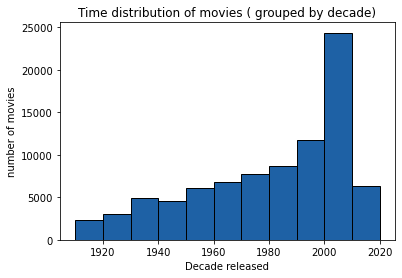

In [9]:
# create range of dates for each decade
binwidth = 10
start = int(movie_metadata.Release.min()/10)*10
end  = (int(movie_metadata.Release.max()/10)+2)*10
decade_bins = range(start, end , binwidth)

# after removing years that do not have enough movies we plot the time distribution of the movies
# we see that each decade ( with a few exeptions: 1940s* and 2010**) the number of movies is increasing
# *: the decrease is probably due to the second world war
# **: we only have movies up to 2013 ( included)

ax = plt.hist(processed.Release, bins=decade_bins, color =sns.color_palette("RdBu",10)[9], edgecolor = 'black')
plt.xlabel('Decade released')
plt.ylabel("number of movies")
plt.title("Time distribution of movies ( grouped by decade)")
plt.show()

In [10]:
# to explore prevalence of genres between males and females combine the movie_metadata 
# and characters dataframes
movie_metadata_for_merge = movie_metadata.rename(columns={'Name': "MovieName"})
characters_for_merge = characters.rename(columns={'Name': "ActorName"})
characters_for_merge = characters_for_merge.drop(columns=['FreebaseID', 'Release' ])
actor_movie_df = movie_metadata_for_merge.merge(characters_for_merge, how='inner', on='WikiID')

In [11]:
# we compute how many roles are played by men and women 
print("Role numbers divided by sex")
roles_by_sex = actor_movie_df.Gender.value_counts()
print(f"Male roles: {roles_by_sex.loc['M']}, Female roles: {roles_by_sex.loc['F']}, Total Roles {roles_by_sex.sum()}")
print(f"{round( roles_by_sex.loc['F'] / (roles_by_sex.loc['F'] + roles_by_sex.loc['M']) * 100, 2)}% of roles are female")

# then we see how many actors are male and how many female
print("\nActors numbers divided by sex")
actors_by_sex = actor_movie_df.groupby('Gender')['Freebase actor ID'].unique().apply(len)
print(f"Male actors: {actors_by_sex.loc['M']}, Female actors: {actors_by_sex.loc['F']}, total actors {actors_by_sex.sum()}")
print(f"{round( actors_by_sex.loc['F'] / (actors_by_sex.loc['F'] + actors_by_sex.loc['M']) * 100, 2)}% of actors are female")

Role numbers divided by sex
Male roles: 61986, Female roles: 31288, Total Roles 93274
33.54% of roles are female

Actors numbers divided by sex
Male actors: 4326, Female actors: 2810, total actors 7136
39.38% of actors are female


# Genres

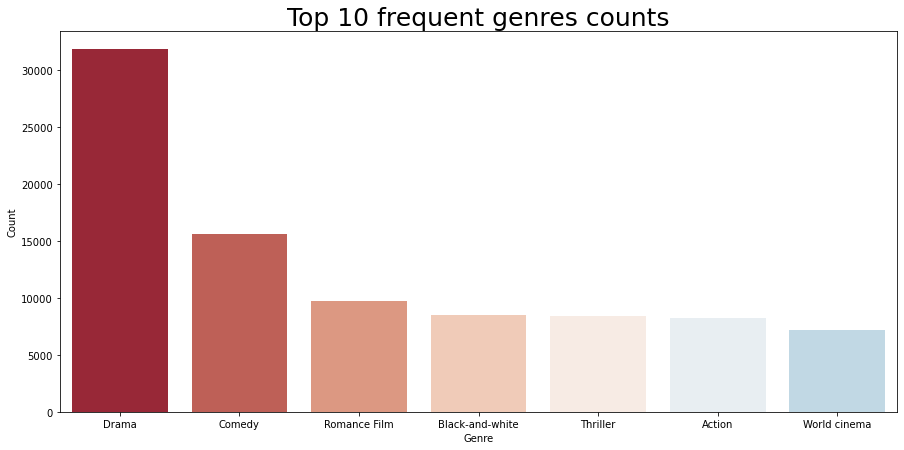

In [12]:
FREQUENCY_THRESH = 7000
genres_numbers = movie_metadata.Genres.explode().value_counts()
most_popular_genres = genres_numbers[genres_numbers > FREQUENCY_THRESH]
most_popular_genres

sns.set_palette(sns.color_palette("RdBu",10))
plt.figure(figsize=(15,7))
gfg = sns.barplot(x=most_popular_genres.index, y=most_popular_genres.values)
gfg.set(xlabel='Genre', ylabel='Count')
gfg.axes.set_title( 'Top 10 frequent genres counts', fontsize=25)
plt.show()

## All Time Period

In [13]:
gender_genre = actor_movie_df.explode('Genres').groupby( [ "Gender", "Genres"] ).size()
female = pd.DataFrame(gender_genre.F, columns=[ "F_counts"])
male = pd.DataFrame(gender_genre.M, columns=[ "M_counts"])
genres_gender_counts = female.merge(male, on='Genres', how='inner')
genres_gender_counts['total_counts'] = genres_gender_counts.F_counts + genres_gender_counts.M_counts
genres_gender_counts['Men'] = (genres_gender_counts.M_counts / genres_gender_counts.total_counts).round(2)
genres_gender_counts['Women'] = (genres_gender_counts.F_counts / genres_gender_counts.total_counts).round(2)

genres_gender_counts = genres_gender_counts.sort_values('total_counts', ascending=False)
genres_gender_counts.head(5)

,F_counts,M_counts,total_counts,Men,Women
Genres,,,,,
Drama,17493,31548,49041,0.64,0.36
Comedy,10379,19460,29839,0.65,0.35
Romance Film,8319,12041,20360,0.59,0.41
Action,4738,13804,18542,0.74,0.26
Thriller,5523,12725,18248,0.70,0.30


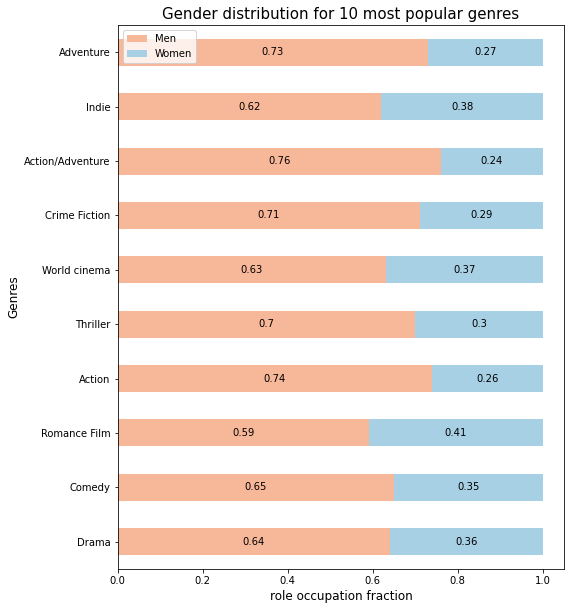

In [14]:
ax = genres_gender_counts[['Men', 'Women']].head(10).plot.barh(stacked=True, figsize = (8,10), color=sns.color_palette("RdBu",2))
ax.legend(loc='upper left')
ax.set_title("Gender distribution for 10 most popular genres", size=15)
ax.set_xlabel("role occupation fraction", size=12)
ax.set_ylabel("Genres", size=12)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='k')
plt.show()

## 2013

In [15]:
actor_2013_movie_df = actor_movie_df[actor_movie_df.Release == 2013]

In [16]:
gender_genre = actor_2013_movie_df.explode('Genres').groupby( [ "Gender", "Genres"] ).size()
female = pd.DataFrame(gender_genre.F, columns=[ "F_counts"])
male = pd.DataFrame(gender_genre.M, columns=[ "M_counts"])
genres_gender_counts = female.merge(male, on='Genres', how='inner')
genres_gender_counts['total_counts'] = genres_gender_counts.F_counts + genres_gender_counts.M_counts
genres_gender_counts['Men'] = (genres_gender_counts.M_counts / genres_gender_counts.total_counts).round(2)
genres_gender_counts['Women'] = (genres_gender_counts.F_counts / genres_gender_counts.total_counts).round(2)

genres_gender_counts = genres_gender_counts.sort_values('total_counts', ascending=False)
genres_gender_counts.head(5)

,F_counts,M_counts,total_counts,Men,Women
Genres,,,,,
Action,41,105,146,0.72,0.28
Thriller,34,82,116,0.71,0.29
Drama,30,78,108,0.72,0.28
Adventure,32,72,104,0.69,0.31
Science Fiction,25,60,85,0.71,0.29


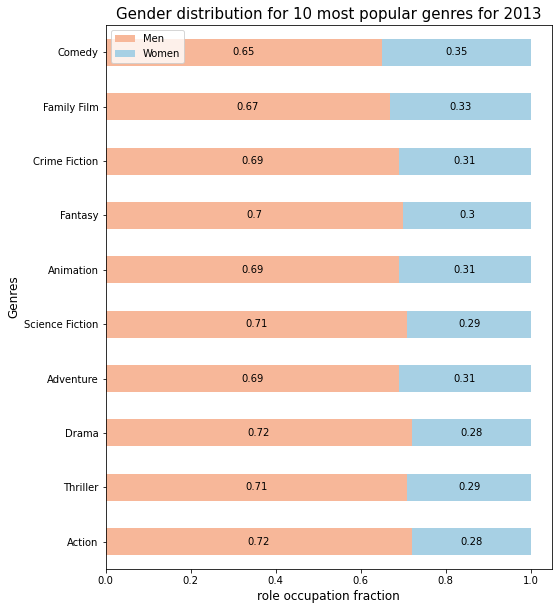

In [17]:
ax = genres_gender_counts[['Men', 'Women']].head(10).plot.barh(stacked=True, figsize = (8,10), color=sns.color_palette("RdBu",2))
ax.legend(loc='upper left')
ax.set_title("Gender distribution for 10 most popular genres for 2013", size=15)
ax.set_xlabel("role occupation fraction", size=12)
ax.set_ylabel("Genres", size=12)
for container in ax.containers:
    ax.bar_label(container, label_type='center', color='k')
plt.show()

# Actors age with respect to gender

In [18]:
def quartiles(data):
    """
    Method that takes in 1 dimensional data and 
    returns: 1st, second ( median) and 3rd quartile"""
    return [np.quantile(data, x/4) for x in range(1, 4)]

In [19]:
characters.keys()

Index(['WikiID', 'FreebaseID', 'Release', 'Character name', 'Birth', 'Gender',
       'Height (m)', 'Ethnicity', 'Name', 'Age at movie release',
       'Freebase character/actor map ID', 'Freebase character ID',
       'Freebase actor ID'],
      dtype='object')

Women        -- 1st quartile 24.0, median 30.0, 3rd quartile 39.0 | IQR: 15.0
Men          -- 1st quartile 31.0, median 40.0, 3rd quartile 50.0 | IQR: 19.0
All Actors   -- 1st quartile 28.0, median 37.0, 3rd quartile 47.0 | IQR: 19.0


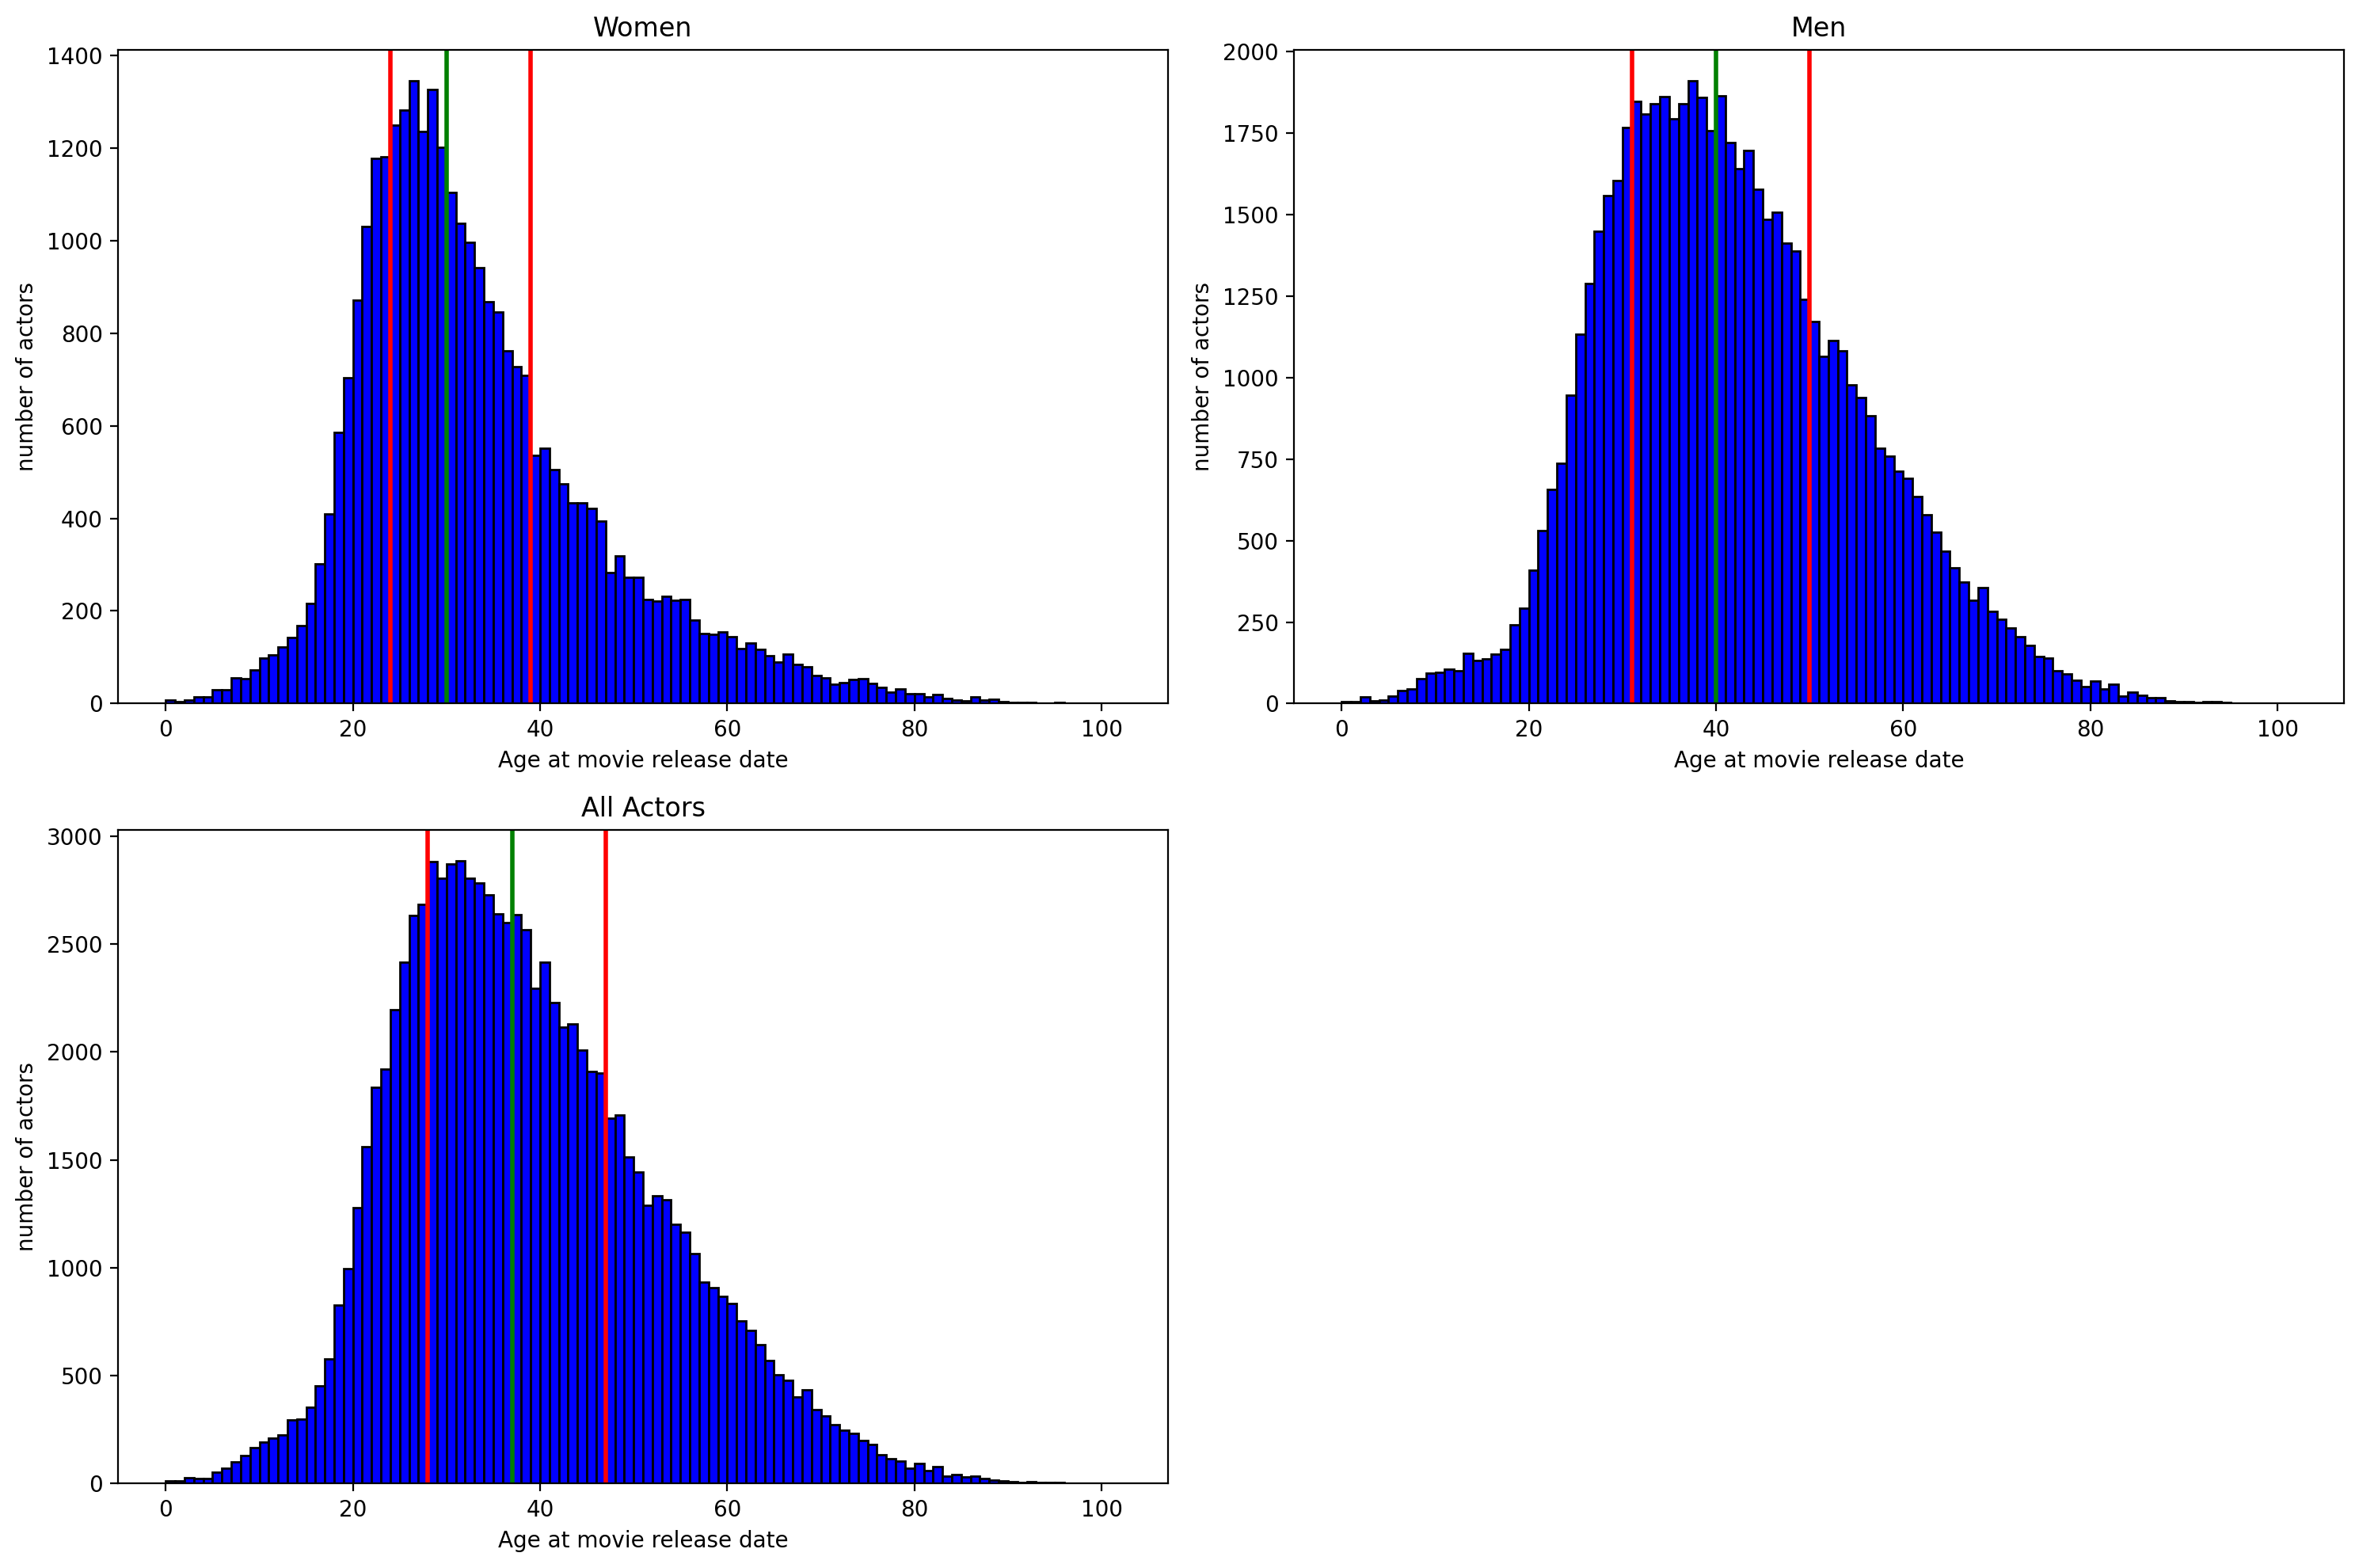

In [20]:
# we then plot the age of the men, women and all the actors at release date of the movie
# We also plot the 1st and 3rd quartile in RED
# and the median in GREEN
# IQR == Interquartile range
from matplotlib.pyplot import figure

categories = [characters[characters['Gender'] == "F"]['Age at movie release'],
              characters[characters['Gender'] == "M"]['Age at movie release'],
              characters['Age at movie release']]

cat_names = [ "Women", "Men", "All Actors"]

max_age = int(characters['Age at movie release'].max())


figure(figsize=(15, 10), dpi=200)
for i, data in enumerate(categories):
    
    # Set up the plot
    ax = plt.subplot(2, 2, i + 1)
    
    # Draw the plot
    ax.hist(data, [x for x in range(max_age)], color = 'blue', edgecolor = 'black')
    stats = quartiles(data)
    print(f"{cat_names[i]:12} -- 1st quartile {stats[0]}, median {stats[1]}, 3rd quartile {stats[2]} | IQR: {stats[2] - stats[0]}")
    ax.axvline(stats[0], color='r', linewidth=2)
    ax.axvline(stats[1], color='g', linewidth=2)
    ax.axvline(stats[2], color='r', linewidth=2)
    ax.set_xlabel('Age at movie release date')
    ax.set_ylabel("number of actors")
    
#     Title and labels
    ax.set_title(cat_names[i])

plt.tight_layout()
plt.show()

F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles

                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd
1920 - 1930 | F:[20.0, 22.0, 24.0] IQR: 4  | M:[7.0, 10.0, 22.0]  IQR: 15 | A:[10.0, 21.0, 24.0] IQR: 14 | 
1930 - 1940 | F:[21.0, 25.0, 28.0] IQR: 7  | M:[24.0, 28.0, 31.0] IQR: 7  | A:[22.0, 27.0, 30.0] IQR: 8  | 
1940 - 1950 | F:[21.0, 26.0, 32.0] IQR: 11 | M:[29.0, 34.0, 38.0] IQR: 9  | A:[26.0, 32.0, 37.0] IQR: 11 | 
1950 - 1960 | F:[21.0, 26.0, 34.0] IQR: 13 | M:[31.0, 37.0, 44.0] IQR: 13 | A:[27.0, 34.0, 42.0] IQR: 15 | 
1960 - 1970 | F:[23.0, 29.0, 36.0] IQR: 13 | M:[33.0, 40.0, 48.0] IQR: 15 | A:[29.0, 36.0, 46.0] IQR: 17 | 
1970 - 1980 | F:[23.0, 29.0, 39.0] IQR: 16 | M:[31.0, 38.0, 49.0] IQR: 18 | A:[28.0, 36.0, 46.0] IQR: 18 | 
1980 - 1990 | F:[22.0, 29.0, 38.0] IQR: 16 | M:[30.0, 38.0, 48.0] IQR: 18 | A:[27.0, 35.0, 46.0] IQR: 19 | 
1990 - 2000 | F:[23.0, 30.0, 39.0] IQR: 16 | M:[31

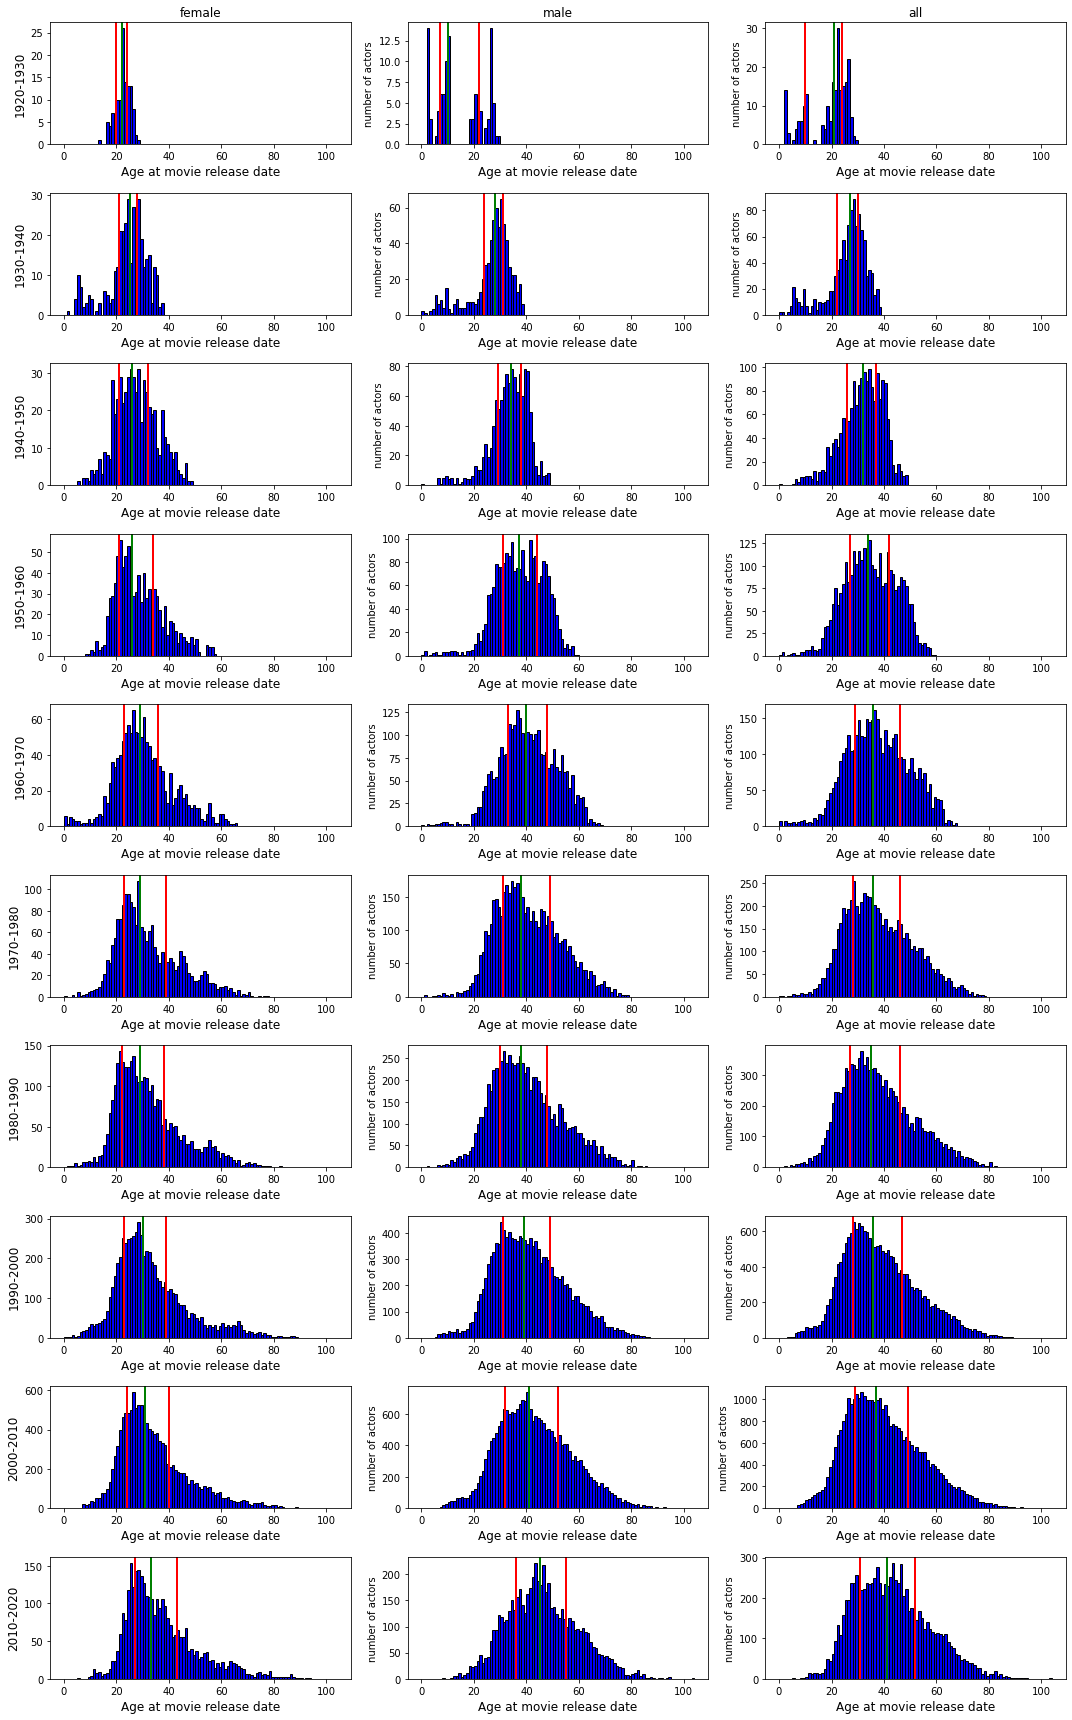

In [21]:
sex_df_dict = {'female': characters[characters['Gender'] == "F"],
              'male': characters[characters['Gender'] == "M"],
              'all': characters}

cat_names = [ "Women", "Men", "All Actors"]


fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(15, 24))

print("F = Female, M = Male, A = all actors,  IQR = interquartile range, 1st, 2nd, 3rd are the quartiles\n")
print("                 1st | 2nd | 3rd                 1st | 2nd | 3rd               1st | 2nd | 3rd")
for row, date_range in enumerate(decade_bins[1:-1]):
    print(date_range,"-",date_range+10, end=' | ')
    for column, sex in enumerate(sex_df_dict.keys()):
        
        # Draw the plot
        rel_y = np.array([date for date in  sex_df_dict[sex]['Release']])
        data = sex_df_dict[sex][ (rel_y  >= date_range ) & (rel_y  < date_range + 10) ]['Age at movie release']
        axes[row,column].hist(data, [x for x in range(105)], color = 'blue', edgecolor = 'black')
        data = data.values
        if( data.shape[0] > 10):
            bstats = quartiles(data)
            print( f"{sex[0].upper()}:{str(bstats):18} IQR: {str(int(bstats[2] - bstats[0])):2} | ", end='' )

            axes[row,column].axvline(bstats[0], color='r', linewidth=2)
            axes[row,column].axvline(bstats[1], color='g', linewidth=2)
            axes[row,column].axvline(bstats[2], color='r', linewidth=2)
                
            axes[row,column].set_xlabel('Age at movie release date', size=12)
            axes[row,column].set_ylabel("number of actors")

    print()
    
for ax, col in zip(axes[0], sex_df_dict.keys()):
    ax.set_title(col)

for ax, row in zip(axes[:,0], decade_bins[1:]):
    ax.set_ylabel(f"{row}-{row+10}", size='large' )
    
plt.tight_layout()
plt.show()


In [22]:
# we also inspect the ratio of male female roles over time 
ages = np.zeros((len(decade_bins[1:-1]), 3))
for row, date_range in enumerate(decade_bins[1:-1]):
    for column, sex in enumerate(sex_df_dict.keys()):
        
        rel_y = np.array([date for date in  sex_df_dict[sex]['Release']])
        data = sex_df_dict[sex][ (rel_y  >= date_range ) & (rel_y  < date_range + 10 )]['Age at movie release']
        
        ages[row,column] = data.shape[0]
    
for row, date_range in enumerate(decade_bins[1:-1]):
    print(f"{date_range}-{date_range+10}", end=' | ')
    print( f"Females roles represent: {round(ages[row,0] / ages[row,2]* 100,2):4.2f}% of roles")

1920-1930 | Females roles represent: 52.68% of roles
1930-1940 | Females roles represent: 34.92% of roles
1940-1950 | Females roles represent: 31.84% of roles
1950-1960 | Females roles represent: 30.50% of roles
1960-1970 | Females roles represent: 29.99% of roles
1970-1980 | Females roles represent: 29.70% of roles
1980-1990 | Females roles represent: 29.13% of roles
1990-2000 | Females roles represent: 32.76% of roles
2000-2010 | Females roles represent: 36.26% of roles
2010-2020 | Females roles represent: 35.28% of roles


In [23]:
# finally we started looking at the actors with the most roles and inspecting their sex
characters.groupby(['Name', 'Gender'])['Freebase actor ID' ].count().sort_values(ascending=False).head(20)

Name                Gender
Mel Blanc           M         639
Mithun Chakraborty  M         291
Mohanlal            M         217
Mammootty           M         207
Amitabh Bachchan    M         198
Prakash Raj         M         187
Kamal Haasan        M         183
Anupam Kher         M         181
John Wayne          M         173
Shakti Kapoor       M         172
Rajnikanth          M         162
Nassar              M         159
Amrish Puri         M         153
Nedumudi Venu       M         151
Paresh Rawal        M         150
Gulshan Grover      M         141
Jackie Shroff       M         128
Asrani              M         125
Rekha Ganesan       F         125
Vivek               M         125
Name: Freebase actor ID, dtype: int64

In [32]:
sns.color_palette("RdBu",2)[2]

(0.9686274509803922, 0.7176470588235293, 0.5999999999999999)

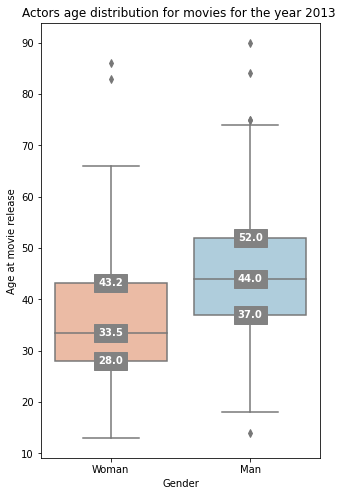

In [35]:

letter2sex = {"M" : "Man", "F" : "Woman"}
actors_start_2013 = characters[characters.Release == 2013].replace({"Gender": letter2sex})

fig, ax = plt.subplots(figsize=(5,8))
plt.suptitle('')
_=sns.boxplot(x='Gender', y='Age at movie release', data=actors_start_2013, ax=ax, palette=sns.color_palette("RdBu",2)).set_title('Actors age distribution for movies for the year 2013 ')



lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    for x in [0,1,4]:
        y = round(lines[x+cat*6].get_ydata()[0],1) 
        ax.text(
            cat, 
            y, 
            f'{y}', 
            ha='center', 
            va='center', 
            fontweight='semibold', 
            size=10,
            color='white',
            bbox=dict(facecolor='#828282', edgecolor='#828282')
        )
        
fig.savefig("data/sex_ages_2013.png") 

# LGBT

In [25]:
lgbt = ["gay", "gay interest", "gay themed", "lgbt"]

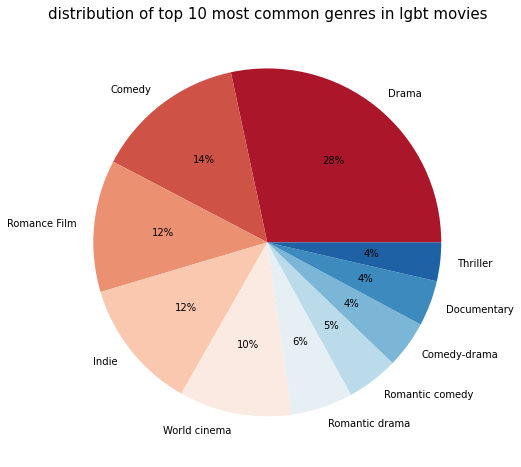

In [27]:
exploded_genres = movie_metadata.explode("Genres")
lgbt_movies_ids = exploded_genres[exploded_genres.Genres.str.lower().isin(lgbt)].FreebaseID	.unique()
lgbt_movies = movie_metadata[ movie_metadata.FreebaseID.isin(lgbt_movies_ids)]
# explode gender column and remove rows containing tags we used for filtering
lgbt_movies = lgbt_movies.explode("Genres")#.Genres.value_counts()[:10].plot.pie()
lgbt_movies = lgbt_movies[ ~lgbt_movies.Genres.str.lower().isin(lgbt)]
# get counts of top 10 most popular genres
top10lgbt_genres = lgbt_movies.Genres.value_counts()[:10]


fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(top10lgbt_genres.values, labels=top10lgbt_genres.index, autopct='%.0f%%' )
ax.set_title("distribution of top 10 most common genres in lgbt movies", size=15)
fig.savefig("data/lgbt_genres.png") 
plt.show()